
## Regex vs NLP vs CyNER vs LLMs

Tim Angevare - t.p.angevare@student.utwente.nl

This notebook evaluates four approaches for extracting Indicators of Compromise (IoCs) from The Cipher Trail cybercrime investigation document:
1. **Regex-based extraction** - Pattern matching
2. **NLP-based extraction** - spaCy with custom rules
3. **Gliner-PII extraction** - 
4. **LLM-based extraction** - Multiple open-source LLMs with prompt engineering

**Target IoC Types:**
- Email addresses
- IP addresses (v4/v6)
- Financial addresses (IBAN, BTC, etc)
- Person names
- Locations
- Domains
- Usernames

Methodology based on cake recipe
https://github.com/jjsantanna/cake_recipe_for_students/blob/master/cake_of_llm.md

## Section 1: Setup & Environment

In [116]:
import os
from datetime import datetime
import json
from pathlib import Path
import numpy as np
import pandas as pd
import re
from difflib import SequenceMatcher
from collections import defaultdict

#for LLM extraction
import ollama

# For NLP extraction
import spacy

# For visualization
import matplotlib.pyplot as plt
import seaborn as sns

# For GLiNER state of the art extraction
from gliner import GLiNER

## Section 2: Dataset Preparation
### 2.1 Load The Cipher Trail Document

In [117]:
documents_path = Path('Cipher mails')

print(f"documents: {len(list(documents_path.glob('*.json')))}")

documents: 13


In [118]:
def parse_json_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    return data['entities'], data['text']

dataset = {
    "gt_entities" : [],
    "regex_entities" : [],
    "regex_metrics" : [],
    "regex_time" : [],
    "nlp_entities" : [],
    "cyner_entities" : [],
    "text" : [],
    "filenames" : []
}

for file in documents_path.glob('*.json'):
    entities, text = parse_json_file(file)
    dataset['gt_entities'].append(entities)
    dataset['text'].append(text)
    dataset['filenames'].append(file.name)

print(f"Loaded {len(dataset['filenames'])} documents.")
types = []

for files in dataset['gt_entities']:
    for entity in files:
        if entity['type'] not in types:
            types.append(entity['type'])

print(f"Entity types in ground truth: {types}")

Loaded 13 documents.
Entity types in ground truth: ['EMAIL', 'BTC', 'PERSON', 'LOCATION', 'IP', 'TOX', 'URL', 'PHONE']


## Section 3: Evaluation Metrics

These functions calculate precision, recall, and F1-score for entity extraction.

In [119]:
def compute_overlap(span1, span2):
    """
    Compute Intersection over Union (IoU) for two spans.
    span: (start, end) tuple
    """
    start1, end1 = span1
    start2, end2 = span2
    
    # Compute intersection
    intersection_start = max(start1, start2)
    intersection_end = min(end1, end2)
    
    if intersection_start >= intersection_end:
        return 0.0
    
    intersection = intersection_end - intersection_start
    
    # Compute union
    union = (end1 - start1) + (end2 - start2) - intersection
    
    return intersection / union if union > 0 else 0.0


def entity_matches(pred_entity, gt_entity, match_type='partial'):
    """
    Check if predicted entity matches ground truth entity.
    
    Args:
        pred_entity: dict with keys 'text', 'type', 'start_pos', 'end_pos'
        gt_entity: dict with keys 'text', 'type', 'start_pos', 'end_pos'
        match_type: 'exact' (exact span match) or 'partial' (IoU > 0.5)
    
    Returns:
        float: 1.0 for exact match, 0.5 for partial match, 0.0 for no match
    """
    # Type must match
    if pred_entity['type'].lower() != gt_entity['type'].lower():
        return 0.0
    
    # If positions are not available, use text matching
    if pred_entity.get('start_pos', -1) == -1 or gt_entity.get('start_pos', -1) == -1:
        if pred_entity['text'].lower() == gt_entity['text'].lower():
            return 1.0
        return 0.0
    
    pred_span = (pred_entity['start_pos'], pred_entity['end_pos'])
    gt_span = (gt_entity['start_pos'], gt_entity['end_pos'])
    
    if match_type == 'exact':
        # Exact span match
        if pred_span == gt_span:
            return 1.0
        return 0.0
    
    elif match_type == 'partial':
        # Partial match using IoU
        iou = compute_overlap(pred_span, gt_span)
        if iou >= 0.5:
            return 0.5  # Partial credit
        return 0.0
    
    return 0.0


def calculate_ner_metrics(predicted_entities, ground_truth_entities, match_type='partial'):
    """
    Calculate NER metrics: Precision, Recall, F1-score.
    
    Args:
        predicted_entities: list of dicts with keys 'text', 'type', 'start_pos', 'end_pos'
        ground_truth_entities: list of dicts with keys 'text', 'type', 'start_pos', 'end_pos'
        match_type: 'exact' or 'partial'
    
    Returns:
        dict with 'precision', 'recall', 'f1', 'tp', 'fp', 'fn'
    """
    # Handle edge case: both empty lists = perfect score (correctly predicted no entities)
    if len(predicted_entities) == 0 and len(ground_truth_entities) == 0:
        return {
            'precision': 1.0,
            'recall': 1.0,
            'f1': 1.0,
            'tp': 0.0,
            'fp': 0,
            'fn': 0,
            'fp_entities': [],
            'fn_entities': []
        }
    
    TP = 0.0
    FP_entities = []
    
    # Track which GT entities have been matched
    matched_gt = set()
    
    # Check each predicted entity
    for pred_ent in predicted_entities:
        best_match_score = 0.0
        best_match_idx = -1
        
        for idx, gt_ent in enumerate(ground_truth_entities):
            if idx in matched_gt:
                continue
            
            score = entity_matches(pred_ent, gt_ent, match_type)
            if score > best_match_score:
                best_match_score = score
                best_match_idx = idx
        
        if best_match_score > 0:
            TP += best_match_score
            matched_gt.add(best_match_idx)
        else:
            FP_entities.append(pred_ent)
    
    # Count unmatched ground truth entities as false negatives
    FN_entities = [gt_entity for i, gt_entity in enumerate(ground_truth_entities) if i not in matched_gt]
    
    FP = len(FP_entities)
    FN = len(FN_entities)
    
    # Calculate metrics
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0.0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0.0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0
    
    return {
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'tp': TP,
        'fp': FP,
        'fn': FN,
        'fp_entities' : FP_entities,
        'fn_entities' : FN_entities
    }


def calculate_ner_metrics_by_type(predicted_entities, ground_truth_entities, match_type='partial'):
    """
    Calculate NER metrics for each entity type separately.
    
    Returns:
        dict: {entity_type: {precision, recall, f1}}
    """
    # Get all unique entity types
    all_types = set()
    for ent in predicted_entities + ground_truth_entities:
        all_types.add(ent['type'].lower())
    
    results = {}
    for ent_type in all_types:
        pred_type = [e for e in predicted_entities if e['type'].lower() == ent_type]
        gt_type = [e for e in ground_truth_entities if e['type'].lower() == ent_type]
        
        metrics = calculate_ner_metrics(pred_type, gt_type, match_type)
        results[ent_type] = metrics
    
    return results

## Section 4: Method 1 - Regex Extraction
### 4.1 Define Regex Patterns

Regex is great for standards like email adresses and BTC wallets but cannot be used for names and locations

In [120]:
# Comprehensive regex patterns for IoC extraction
#second ip is ipv6

ioc_patterns = {
    'EMAIL': r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b',
    'IP': r'\b(?:(?:25[0-5]|2[0-4]\d|1\d{2}|[1-9]?\d)\.){3}(?:25[0-5]|2[0-4]\d|1\d{2}|[1-9]?\d)\b|(?:[0-9a-fA-F]{1,4}:){7}[0-9a-fA-F]{1,4}|(?:[0-9a-fA-F]{1,4}:){1,7}:|(?:[0-9a-fA-F]{1,4}:){1,6}:[0-9a-fA-F]{1,4}|::(?:[0-9a-fA-F]{1,4}:){0,5}[0-9a-fA-F]{1,4}|(?:[0-9a-fA-F]{1,4}:){1,5}(?::[0-9a-fA-F]{1,4}){1,2}',
    'PHONE': r'\+(\d{1,3})[\s.-]?\(?\d{1,4}\)?[\s.-]?\d{1,4}[\s.-]?\d{1,9}',
    'URL': r'(https?|ftp|sftp)://((?:[a-zA-Z0-9.-]+(?:\.[a-zA-Z]{2,}))|(?:(?:25[0-5]|2[0-4]\d|1\d{2}|[1-9]?\d)\.){3}(?:25[0-5]|2[0-4]\d|1\d{2}|[1-9]?\d)|\[(?:[0-9a-fA-F:]+)\])(?::\d+)?(/[^\s]*)?',
    'TOX': r'\b[A-Fa-f0-9]{76}\b',
    'IBAN': r'\b[A-Z]{2}\d{2}[A-Z0-9]{4,30}\b',
    'BTC': r'\b(bc1|[13])[a-zA-HJ-NP-Z0-9]{25,39}\b',
    'ETH': r'\b0x[a-fA-F0-9]{40}\b',
    'XMR': r'\b4[0-9AB][1-9A-HJ-NP-Za-km-z]{93}\b',
    'LTC': r'\b[LM3][a-km-zA-HJ-NP-Z1-9]{26,33}\b',
    #'FINANCIAL_ACCOUNT' : r'/^AL\d{10}[0-9A-Z]{16}$|^AD\d{10}[0-9A-Z]{12}$|^AT\d{18}$|^BH\d{2}[A-Z]{4}[0-9A-Z]{14}$|^BE\d{14}$|^BA\d{18}$|^BG\d{2}[A-Z]{4}\d{6}[0-9A-Z]{8}$|^HR\d{19}$|^CY\d{10}[0-9A-Z]{16}$|^CZ\d{22}$|^DK\d{16}$|^FO\d{16}$|^GL\d{16}$|^DO\d{2}[0-9A-Z]{4}\d{20}$|^EE\d{18}$|^FI\d{16}$|^FR\d{12}[0-9A-Z]{11}\d{2}$|^GE\d{2}[A-Z]{2}\d{16}$|^DE\d{20}$|^GI\d{2}[A-Z]{4}[0-9A-Z]{15}$|^GR\d{9}[0-9A-Z]{16}$|^HU\d{26}$|^IS\d{24}$|^IE\d{2}[A-Z]{4}\d{14}$|^IL\d{21}$|^IT\d{2}[A-Z]\d{10}[0-9A-Z]{12}$|^[A-Z]{2}\d{5}[0-9A-Z]{13}$|^KW\d{2}[A-Z]{4}22!$|^LV\d{2}[A-Z]{4}[0-9A-Z]{13}$|^LB\d{6}[0-9A-Z]{20}$|^LI\d{7}[0-9A-Z]{12}$|^LT\d{18}$|^LU\d{5}[0-9A-Z]{13}$|^MK\d{5}[0-9A-Z]{10}\d{2}$|^MT\d{2}[A-Z]{4}\d{5}[0-9A-Z]{18}$|^MR13\d{23}$|^MU\d{2}[A-Z]{4}\d{19}[A-Z]{3}$|^MC\d{12}[0-9A-Z]{11}\d{2}$|^ME\d{20}$|^NL\d{2}[A-Z]{4}\d{10}$|^NO\d{13}$|^PL\d{10}[0-9A-Z]{,16}n$|^PT\d{23}$|^RO\d{2}[A-Z]{4}[0-9A-Z]{16}$|^SM\d{2}[A-Z]\d{10}[0-9A-Z]{12}$|^SA\d{4}[0-9A-Z]{18}$|^RS\d{20}$|^SK\d{22}$|^SI\d{17}$|^ES\d{22}$|^SE\d{22}$|^CH\d{7}[0-9A-Z]{12}$|^TN59\d{20}$|^TR\d{7}[0-9A-Z]{17}$|^AE\d{21}$|^GB\d{2}[A-Z]{4}\d{14}$/'
}

def refang(text: str) -> str:
    """Convert defanged IoCs back to normal format"""
    text = re.sub(r'\[(\.|dot)\]', '.', text, flags=re.I)
    text = re.sub(r'hxxp', 'http', text, flags=re.I)
    text = re.sub(r'\[@\]', '@', text)
    return text

print("=== Regex Patterns ===")
for ioc_type, pattern in ioc_patterns.items():
    print(f"{ioc_type}: {pattern}")

=== Regex Patterns ===
EMAIL: \b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b
IP: \b(?:(?:25[0-5]|2[0-4]\d|1\d{2}|[1-9]?\d)\.){3}(?:25[0-5]|2[0-4]\d|1\d{2}|[1-9]?\d)\b|(?:[0-9a-fA-F]{1,4}:){7}[0-9a-fA-F]{1,4}|(?:[0-9a-fA-F]{1,4}:){1,7}:|(?:[0-9a-fA-F]{1,4}:){1,6}:[0-9a-fA-F]{1,4}|::(?:[0-9a-fA-F]{1,4}:){0,5}[0-9a-fA-F]{1,4}|(?:[0-9a-fA-F]{1,4}:){1,5}(?::[0-9a-fA-F]{1,4}){1,2}
PHONE: \+(\d{1,3})[\s.-]?\(?\d{1,4}\)?[\s.-]?\d{1,4}[\s.-]?\d{1,9}
URL: (https?|ftp|sftp)://((?:[a-zA-Z0-9.-]+(?:\.[a-zA-Z]{2,}))|(?:(?:25[0-5]|2[0-4]\d|1\d{2}|[1-9]?\d)\.){3}(?:25[0-5]|2[0-4]\d|1\d{2}|[1-9]?\d)|\[(?:[0-9a-fA-F:]+)\])(?::\d+)?(/[^\s]*)?
TOX: \b[A-Fa-f0-9]{76}\b
IBAN: \b[A-Z]{2}\d{2}[A-Z0-9]{4,30}\b
BTC: \b(bc1|[13])[a-zA-HJ-NP-Z0-9]{25,39}\b
ETH: \b0x[a-fA-F0-9]{40}\b
XMR: \b4[0-9AB][1-9A-HJ-NP-Za-km-z]{93}\b
LTC: \b[LM3][a-km-zA-HJ-NP-Z1-9]{26,33}\b


### 4.2 Extract IoCs with Regex

In [121]:
def extract_iocs_regex(text, patterns):
    """
    Extract IoCs from text using regex patterns.
    
    Args:
        text: source text
        patterns: dict of {ioc_type: regex_pattern}
    
    Returns:
        list of entity dicts with 'text', 'type', 'start_pos', 'end_pos'
    """
    defanged_text = refang(text)
    
    entities = []
    
    for ioc_type, pattern in patterns.items():
        for match in re.finditer(pattern, defanged_text, re.IGNORECASE):
            entity = {
                'text': match.group(),
                'type': ioc_type,
                'start_pos': match.start(),
                'end_pos': match.end()
            }
            entities.append(entity)
    
    return entities

# Extract IoCs using regex

for text in dataset['text']:
    regex_start_time = datetime.now()
    entities = extract_iocs_regex(text, ioc_patterns)
    dataset['regex_entities'].append(entities)
    regex_elapsed_time = (datetime.now() - regex_start_time).total_seconds()
    dataset['regex_time'].append(regex_elapsed_time)
    print(f"=== Regex Extraction Results ===")
    print(f"Extracted {len(entities)} entities in {regex_elapsed_time:.4f} seconds")

=== Regex Extraction Results ===
Extracted 3 entities in 0.0007 seconds
=== Regex Extraction Results ===
Extracted 2 entities in 0.0004 seconds
=== Regex Extraction Results ===
Extracted 1 entities in 0.0005 seconds
=== Regex Extraction Results ===
Extracted 2 entities in 0.0009 seconds
=== Regex Extraction Results ===
Extracted 1 entities in 0.0005 seconds
=== Regex Extraction Results ===
Extracted 2 entities in 0.0012 seconds
=== Regex Extraction Results ===
Extracted 2 entities in 0.0002 seconds
=== Regex Extraction Results ===
Extracted 3 entities in 0.0008 seconds
=== Regex Extraction Results ===
Extracted 2 entities in 0.0003 seconds
=== Regex Extraction Results ===
Extracted 6 entities in 0.0003 seconds
=== Regex Extraction Results ===
Extracted 3 entities in 0.0003 seconds
=== Regex Extraction Results ===
Extracted 3 entities in 0.0003 seconds
=== Regex Extraction Results ===
Extracted 3 entities in 0.0004 seconds


### 4.3 Calculate Metrics

In [122]:
def calc_avg_ner_metrics(pred_entities):
    precision = []
    recall = []
    f1 = []
    TP = 0
    FP = 0
    FN = 0

    for idx in range(len(dataset['filenames'])):
        regex_metrics = calculate_ner_metrics(
            pred_entities[idx],
            dataset['gt_entities'][idx],
            match_type='partial'
        )
        precision.append(regex_metrics['precision'])
        recall.append(regex_metrics['recall'])
        f1.append(regex_metrics['f1'])
        TP += regex_metrics['tp']
        FP += regex_metrics['fp']
        FN += regex_metrics['fn']
    avg_metrics = {
        'precision': np.mean(precision),
        'recall': np.mean(recall),
        'f1': np.mean(f1),
        'tp': TP,
        'fp': FP,
        'fn': FN
    }
    return avg_metrics

dataset['regex_metrics'] = calc_avg_ner_metrics(dataset['regex_entities'])


In [123]:

def calc_avg_ner_metrics_by_type(pred_entities):
    type_stats = defaultdict(lambda: defaultdict(list))

    for idx in range(len(dataset['filenames'])):
        regex_metrics_by_type = calculate_ner_metrics_by_type(
            pred_entities[idx],
            dataset['gt_entities'][idx],
            match_type='partial'
        )
        for entity_type, metrics in regex_metrics_by_type.items():
            for metric_name, value in metrics.items():
                type_stats[entity_type][metric_name].append(value)

    averages = {}
    for entity_type, metrics_lists in type_stats.items():
        averages[entity_type] = {}
        for metric_name, values in metrics_lists.items():
            if metric_name != 'fp_entities' and metric_name != 'fn_entities':
                averages[entity_type][metric_name] = sum(values) / len(values)
    return averages


In [124]:
dataset['regex_type_metrics'] = calc_avg_ner_metrics_by_type(dataset['regex_entities'])
# Create a DataFrame for display
print(dataset['regex_type_metrics'])

df = pd.DataFrame(dataset['regex_type_metrics']).T
print(df)

{'person': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'tp': 0.0, 'fp': 0.0, 'fn': 3.3076923076923075}, 'email': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'tp': 1.6666666666666667, 'fp': 0.0, 'fn': 0.0}, 'btc': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'tp': 1.5, 'fp': 0.0, 'fn': 0.0}, 'location': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'tp': 0.0, 'fp': 0.0, 'fn': 1.6}, 'ip': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'tp': 1.5, 'fp': 0.0, 'fn': 0.0}, 'tox': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'tp': 0.0, 'fp': 0.0, 'fn': 1.0}, 'phone': {'precision': 0.75, 'recall': 0.75, 'f1': 0.75, 'tp': 1.0, 'fp': 0.0, 'fn': 0.25}, 'url': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'tp': 0.0, 'fp': 1.6666666666666667, 'fn': 1.6666666666666667}}
          precision  recall    f1        tp        fp        fn
person         0.00    0.00  0.00  0.000000  0.000000  3.307692
email          1.00    1.00  1.00  1.666667  0.000000  0.000000
btc            1.00    1.00  1.00  1.500000 

## Section 5: Method 2 - NLP Extraction
### 5.1 Setup NLP Pipeline

Hypothesis is that NLP will be beter in extracting locations and names

In [125]:
# Load spaCy model
try:
    nlp = spacy.load('en_core_web_sm')
    print("spaCy model loaded: en_core_web_sm")
except:
    print("spaCy model not found. Installing...")
    import subprocess
    subprocess.run(['python', '-m', 'spacy', 'download', 'en_core_web_sm'])
    nlp = spacy.load('en_core_web_sm')
    print("spaCy model installed and loaded")

spaCy model loaded: en_core_web_sm


In [126]:
ruler = nlp.add_pipe("entity_ruler", before="ner")
patterns = [
    {"label": "EMAIL", "pattern": [{"LIKE_EMAIL": True}]},
    {"label": "URL", "pattern": [{"LIKE_URL": True}]},
]
ruler.add_patterns(patterns)

### 5.2 Extract Entities with NLP

In [127]:
entities = nlp('Hello my name is Tim and my email is t.p.angevare@student.utwente.nl. His iban is NL46RABO0304375722').ents
for ent in entities:
    print(ent.text, ent.label_)

Tim PERSON
t.p.angevare@student.utwente.nl EMAIL
NL46RABO0304375722 ORG


In [128]:
def extract_iocs_nlp(text, nlp_model):
    """
    Extract IoCs using NLP (spaCy) + hybrid regex approach.
    
    Args:
        text: source text
        nlp_model: spaCy model
        regex_patterns: dict of regex patterns for technical IoCs
    
    Returns:
        list of entity dicts
    """
    entities = []
    
    # Process text with spaCy
    doc = nlp_model(text)
    
    # Entity type mapping from spaCy to our IoC types
    spacy_to_ioc_mapping = {
        'PERSON': 'PERSON',
        'GPE': 'LOCATION',  # Geopolitical entity
        'LOC': 'LOCATION',
        'ORG': 'ORGANIZATION',
        'EMAIL' : 'EMAIL',
        'FINANCIAL_ACOUNT' : 'FINANCIAL_ACCOUNT',
        'IP' : 'IP',
        'PHONE' : 'PHONE',
        'URL' : 'URL'
    }
    
    # Extract named entities from spaCy
    for ent in doc.ents:
        if ent.label_ in spacy_to_ioc_mapping:
            entity = {
                'text': ent.text,
                'type': spacy_to_ioc_mapping[ent.label_],
                'start_pos': ent.start_char,
                'end_pos': ent.end_char
            }
            entities.append(entity)
    
    return entities

In [129]:
# Extract IoCs using NLP

dataset['nlp_entities'] = []
dataset['nlp_time'] = []

for text in dataset['text']:
    nlp_start_time = datetime.now()
    nlp_entities = extract_iocs_nlp(text, nlp)
    dataset['nlp_entities'].append(nlp_entities)
    nlp_elapsed_time = (datetime.now() - nlp_start_time).total_seconds()
    dataset['nlp_time'].append(nlp_elapsed_time)

    print(f"=== NLP Extraction Results ===")
    print(f"Extracted {len(nlp_entities)} entities in {nlp_elapsed_time:.4f} seconds")
    print(f"\nEntity type distribution:")
    nlp_type_counts = defaultdict(int)


=== NLP Extraction Results ===
Extracted 4 entities in 0.0288 seconds

Entity type distribution:
=== NLP Extraction Results ===
Extracted 6 entities in 0.0173 seconds

Entity type distribution:
=== NLP Extraction Results ===
Extracted 3 entities in 0.0222 seconds

Entity type distribution:
=== NLP Extraction Results ===
Extracted 8 entities in 0.0395 seconds

Entity type distribution:
=== NLP Extraction Results ===
Extracted 3 entities in 0.0238 seconds

Entity type distribution:
=== NLP Extraction Results ===
Extracted 7 entities in 0.0264 seconds

Entity type distribution:
=== NLP Extraction Results ===
Extracted 3 entities in 0.0098 seconds

Entity type distribution:
=== NLP Extraction Results ===
Extracted 9 entities in 0.0331 seconds

Entity type distribution:
=== NLP Extraction Results ===
Extracted 5 entities in 0.0203 seconds

Entity type distribution:
=== NLP Extraction Results ===
Extracted 10 entities in 0.0224 seconds

Entity type distribution:
=== NLP Extraction Results ==

### 5.3 Calculate NLP Metrics

In [130]:
dataset['nlp_metrics'] = calc_avg_ner_metrics(dataset['nlp_entities'])
print(dataset['nlp_metrics'])

{'precision': 0.6541819291819292, 'recall': 0.5423382173382174, 'f1': 0.5848968778833032, 'tp': 47.0, 'fp': 28, 'fn': 41}


In [131]:
dataset['nlp_type_metrics'] = calc_avg_ner_metrics_by_type(dataset['nlp_entities'])
# Create a DataFrame for display
df_nlp = pd.DataFrame(dataset['nlp_type_metrics']).T
print(df_nlp)

              precision    recall        f1        tp        fp        fn
person         0.762821  0.497070  0.587379  1.538462  0.384615  1.769231
organization   0.000000  0.000000  0.000000  0.000000  1.857143  0.000000
email          1.000000  1.000000  1.000000  1.666667  0.000000  0.000000
btc            0.000000  0.000000  0.000000  0.000000  0.000000  1.500000
location       0.611111  0.666667  0.633333  1.166667  0.666667  0.166667
url            0.333333  0.500000  0.388889  0.833333  1.000000  0.000000
ip             0.000000  0.000000  0.000000  0.000000  0.000000  1.500000
tox            0.000000  0.000000  0.000000  0.000000  0.000000  1.000000
phone          0.000000  0.000000  0.000000  0.000000  0.000000  1.250000


### 5.4 Nvidia PII Extraction

Nvidia GLiNER-PII is a specialized NER model fine-tuned on cybersecurity data, designed to recognize:
- Indicators of Compromise (IPs, URLs, file hashes)
- Organization names

In [132]:
model = GLiNER.from_pretrained("nvidia/gliner-PII")

/home/jovyan/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

In [133]:
pred_entities = model.predict_entities("The files arrived encrypted via a secure folder. Anna decrypted them with a shared key from their college days. Inside was a high-resolution scan of the painting and a text file labeled ciphertrail.txt. After several hours of sifting through the image metadata and running analysis tools, Anna discovered a steganographic message that revealed a partial Bitcoin address: bc1q2gdf0hxk6e5nxp72cr9sv5uwx9a0gz0h3p9a4f. It didn't belong to Marcellus. She double-checked.",
                                 labels=ioc_patterns.keys())
for ent in entities:
    print(ent)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Tim
t.p.angevare@student.utwente.nl
NL46RABO0304375722


In [134]:
dataset['PII_entities'] = []
dataset['PII_time'] = []
# Extract IoCs using CyNER
for text in dataset['text']:
    PII_start_time = datetime.now()
    pred_entities = model.predict_entities(text, labels=ioc_patterns.keys())
    PII_entities = []
    for entity in pred_entities:
        PII_entities.append(
            {
                'type' : entity['label'],
                'text' : entity['text'],
                'start_pos' : entity['start'],
                'end_pos' : entity['end']
            }
        )
        
    dataset['PII_entities'].append(PII_entities)
    PII_elapsed_time = (datetime.now() - PII_start_time).total_seconds()
    dataset['PII_time'].append(PII_elapsed_time)

    print(f"\n=== PII Extraction Results ===")
    print(f"Extracted {len(PII_entities)} entities in {PII_elapsed_time:.4f} seconds")

print(PII_entities)


=== PII Extraction Results ===
Extracted 2 entities in 0.3165 seconds

=== PII Extraction Results ===
Extracted 3 entities in 0.2026 seconds

=== PII Extraction Results ===
Extracted 1 entities in 0.2480 seconds

=== PII Extraction Results ===
Extracted 3 entities in 0.3029 seconds

=== PII Extraction Results ===
Extracted 1 entities in 0.2496 seconds

=== PII Extraction Results ===
Extracted 2 entities in 0.2708 seconds

=== PII Extraction Results ===
Extracted 2 entities in 0.1714 seconds

=== PII Extraction Results ===
Extracted 4 entities in 0.3018 seconds

=== PII Extraction Results ===
Extracted 3 entities in 0.3084 seconds

=== PII Extraction Results ===
Extracted 6 entities in 0.2764 seconds

=== PII Extraction Results ===
Extracted 4 entities in 0.2809 seconds

=== PII Extraction Results ===
Extracted 3 entities in 0.2703 seconds

=== PII Extraction Results ===
Extracted 5 entities in 0.2941 seconds


In [135]:
dataset['PII_metrics'] = calc_avg_ner_metrics(dataset['PII_entities'])
print(dataset['PII_metrics'])

dataset['PII_type_metrics'] = calc_avg_ner_metrics_by_type(dataset['PII_entities'])
# Create a DataFrame for display
df_nlp = pd.DataFrame(dataset['PII_type_metrics']).T
print(df_nlp)

{'precision': 0.8782051282051282, 'recall': 0.38394383394383397, 'f1': 0.517311321157475, 'tp': 34.0, 'fp': 5, 'fn': 54}
          precision    recall        f1        tp        fp        fn
person     0.000000  0.000000  0.000000  0.000000  0.000000  3.307692
email      1.000000  1.000000  1.000000  1.666667  0.000000  0.000000
btc        0.166667  0.166667  0.166667  0.166667  0.833333  0.333333
location   0.000000  0.000000  0.000000  0.000000  0.000000  1.600000
ip         1.000000  1.000000  1.000000  1.500000  0.000000  0.000000
tox        1.000000  1.000000  1.000000  1.000000  0.000000  0.000000
phone      1.000000  1.000000  1.000000  1.250000  0.000000  0.000000
url        1.000000  0.833333  0.888889  1.333333  0.000000  0.333333


## Section 6: Method 3 - LLM Extraction
### 6.1 Define Prompts

In [136]:
# Ollama configuration
options = {
    'temperature': 0,
    'top_p': 1,
    'top_k' : 0,
    'seed': 1234,
    'num_ctx': 8192
}

models = ['deepseek-r1:14b', 'gemma3:12b', 'phi4:14b']

In [137]:
final_prompt = """
You are a cyber intelligence analyst with 20 years of experience in the the field.

Your task is to extract any entity from the input text. For each entity found you MUST indicate the type in UPPERCASE. ONLY extract entities if literal entity is present in input text.
The expected entity types are the following:

- EMAIL: email addresses format (user@domain.tld)
- IP: IP addresses (IPv4 x.x.x.x or IPv6)
- BTC: ONLY Bitcoin wallet addresses (26-35 alphanumeric, starting with 1, 3, or bc1) EXCLUDE the word bitcoin or values (for example 2.0 BTC)
- IBAN: iban bank account number
- PERSON: Human names (John Smith, John, Catalina) EXCLUDE initials (for example A.H.) 
- LOCATION: cities, countries, geographic locations
- PHONE: phone numbers in any format
- WEB_RESOURCE: URLs and web addresses EXCLUDE filenames
- TOX: Tox messenger IDs
 
**Output**:
The output MUST be in a JSON object with key 'entities' and the value a list of dictionaries including every entity found. For each entity you MUST indicate the type in UPPERCASE.

**OUTPUT EXAMPLE**:
{
  "entities": [
    {"entity": "target123@darkmail.org", "type": "EMAIL"},
    {"entity": "10.45.67.89", "type": "IP"},
    {"entity": "Thompson", "type": "PERSON"},
    {"entity": "Helsinki", "type": "LOCATION"},
    {"entity": "Tim", "type": "PERSON"}
  ]
}

Return empty array if no entities found in the input text.
PAY ATTENTION to sentences that begin with entity type PERSON, for example Anna.
PAY ATTENTION to when the sentences begin with possesive forms of entity type PERSON, for example Catalina's
PAY ATTENTION to when the sentences contain a FULL NAME, the FULL NAME MUST be extracted as ONE entity.
DO NOT include any entities from the example or the system prompt in your answer.

"""

In [138]:
def parse_llm_output(llm_response):
    """
    Parse LLM output to extract entities.
    Handles various output formats and errors.
    
    Args:
        llm_response: string response from LLM
        source_text: original source text (for finding entity positions)
    
    Returns:
        dict with 'entities' list
    """
    output = {'entities': []}
    
    try:
        # Try to extract JSON from response
        response_clean = llm_response.strip()
        
        # Remove markdown code blocks if present
        if '```json' in response_clean:
            start = response_clean.find('```json') + 7
            end = response_clean.find('```', start)
            response_clean = response_clean[start:end].strip()
        elif '```' in response_clean:
            start = response_clean.find('```') + 3
            end = response_clean.find('```', start)
            response_clean = response_clean[start:end].strip()
        
        # Parse JSON
        parsed = json.loads(response_clean)
        
        # Extract entities
        if 'entities' in parsed:
            for ent in parsed['entities']:
                entity = {
                    'text': ent.get('entity', ent.get('text', '')),
                    'type': ent.get('type', '').lower(),
                    'start_pos': ent.get('start_pos', -1),
                    'end_pos': ent.get('end_pos', -1),
                    'confidence' : ent.get('confidence', ''),
                    'reason' : ent.get('reason', '')
                }
                
                output['entities'].append(entity)
    except json.JSONDecodeError as e:
        print(f"JSON parsing failed: {e}")
    
    except Exception as e:
        print(f"Error parsing LLM output: {e}")
    
    return output

### 6.3 LLM Testing Pipeline

Test a single LLM on text with a specific prompt strategy.

In [139]:
def find_entity_position(entity_text: str, source_text: str, start_search: int = 0):
    """
    Find the character position of an entity in source text.
    Uses case-insensitive exact matching first, then falls back to fuzzy matching.
    
    Args:
        entity_text: The entity text to find
        source_text: The source document text
        start_search: Character position to start searching from
    
    Returns:
        Tuple of (start_pos, end_pos) or (-1, -1) if not found
    """
    if not entity_text or not source_text:
        return (-1, -1)
    
    # Clean up entity text (remove extra whitespace)
    entity_text = ' '.join(entity_text.split())
    
    # Try case-insensitive exact match first
    lower_source = source_text.lower()
    lower_entity = entity_text.lower()
    
    start_pos = lower_source.find(lower_entity, start_search)
    if start_pos != -1:
        end_pos = start_pos + len(entity_text)
        return (start_pos, end_pos)
    
    # Fallback: Try fuzzy matching for minor variations
    # This handles cases where there might be extra spaces or minor differences
    try:
        # Search in windows of text similar to entity length
        window_size = len(entity_text) + 10
        best_ratio = 0.0
        best_pos = (-1, -1)
        
        for i in range(len(source_text) - len(entity_text) + 1):
            window = source_text[i:i + window_size]
            ratio = SequenceMatcher(None, lower_entity, window.lower()).ratio()
            
            if ratio > best_ratio and ratio > 0.8:  # 80% similarity threshold
                best_ratio = ratio
                best_pos = (i, i + len(entity_text))
        
        if best_pos != (-1, -1):
            return best_pos
    except Exception as e:
        print(f"Error in fuzzy matching: {e}")
    
    # Not found
    return (-1, -1)

In [140]:
def chat(model_name, prompt_strategy, text, options, max_retries=3):
    retry_counter = 0
    error = ''
    while retry_counter < max_retries:
        try:
            start_time = datetime.now()
            
            # Call LLM
            response = ollama.chat(
                model=model_name,
                messages=[
                    {"role": "system", "content": prompt_strategy},
                    {"role": "user", "content": text}
                ],
                options=options
            )
            
            elapsed_time = (datetime.now() - start_time).total_seconds()
            llm_output = response['message']['content']

            parsed = parse_llm_output(llm_output)
            
            return  parsed, elapsed_time
            
        except Exception as e:
            error = str(e)
            print(f"Error during LLM call or processing: {e}")
            retry_counter += 1
            print(f"Retrying... ({retry_counter}/{max_retries})")
    
    return {}, 0

In [141]:
def test_llm_on_text(model_name, prompt_strategy, text, ground_truth_entities, options, delimiter='', max_retries=3):
    
    if delimiter == '':
        parsed, elapsed_time = chat(model_name, prompt_strategy, text, options, max_retries)
    else:
        text_arr = text.split(delimiter)
        elapsed_time = 0
        parsed = {'entities' : [], 'confidence' : '', 'reason' : ''}
        for text_chunk in text_arr:
            chunk_parsed, chunk_elapsed_time = chat(model_name, prompt_strategy, text_chunk , options, max_retries)
            elapsed_time += chunk_elapsed_time
            parsed['entities'] += chunk_parsed['entities']
            if 'confidence' in chunk_parsed:
                parsed['confidence'] += chunk_parsed['confidence']
            if 'reason' in chunk_parsed:
                parsed['reason'] += chunk_parsed['reason']
    
    if len(parsed) == 0:
        return {
            'success': False,
            'precision': 0,
            'recall': 0,
            'f1': 0,
            'elapsed_time': 0
        }
    for ent in parsed['entities']:
        start_pos, end_pos = find_entity_position(ent['text'], text)
        ent['start_pos'] = start_pos
        ent['end_pos'] = end_pos
    if ground_truth_entities is not None:
        ner_metrics = calculate_ner_metrics(
            parsed['entities'],
            ground_truth_entities,
            match_type='partial'
        )
                
        return {
            'success': True,
            'precision': ner_metrics['precision'],
            'recall': ner_metrics['recall'],
            'f1': ner_metrics['f1'],
            'tp': ner_metrics['tp'],
            'fp': ner_metrics['fp'],
            'fn': ner_metrics['fn'],
            'predicted_entities': parsed['entities'],
            'gt_entities': ground_truth_entities,
            'fp_entities' : ner_metrics['fp_entities'],
            'fn_entities' : ner_metrics['fn_entities'],
            'elapsed_time': elapsed_time
        }
    else:
        return {
            'success': True,
            'predicted_entities': parsed['entities'],
            'elapsed_time': elapsed_time
        }

In [142]:
def run_llm_experiments_chunks(models, prompt, texts, ground_truth_entities, options, chunks, filenames, output_file='llm_chunk_results.csv'):
    total_experiments = len(models) * len(chunks) * len(texts)
    experiment_count = 0
    
    print(f"Starting LLM context chunking experiments: {total_experiments} total tests")
    print(f"Models: {len(models)}, chunks: {len(chunks)}")
    print("="*80)
    for model in models:
        print(f"\nTesting model: {model}")
        model_results = []
        
        for delimiter in chunks:
            for idx in range(len(texts)):
                filename = filenames[idx]
                experiment_count += 1
                begin_time = datetime.now().strftime("%H:%M:%S")
                print(f"  {begin_time} [{experiment_count}/{total_experiments}] delimeter: {delimiter} File: {filename}" , end=" ")
                if ground_truth_entities is not None:
                    result = test_llm_on_text(model, prompt, texts[idx], ground_truth_entities[idx], options, delimiter)
                else:
                    result = test_llm_on_text(model, prompt, texts[idx], None, options, delimiter)
            
                # Add metadata
                result.update({
                    'model': model,
                    'prompt_strategy': prompt,
                    'delimiter' : delimiter,
                    'file' : filename,
                    'source text' : texts[idx]
                })
                
                model_results.append(result)
                end_time = datetime.now().strftime("%H:%M:%S")
                
                if result['success'] and 'f1' in result:
                    print(f"{end_time} F1: {result['f1']:.3f}, P: {result['precision']:.3f}, R: {result['recall']:.3f}, Time: {result['elapsed_time']:.2f}s")
                elif result['success']:
                    print(f"{end_time} Success, but no F1 calculated. Time: {result['elapsed_time']:.2f}s")
                else:
                    print(f"{end_time} Failed: {result.get('error', 'Unknown error')[:50]}")
        
        # Save incrementally after each model
        results_df = pd.DataFrame(model_results)
        
        if os.path.isfile(output_file):
            results_df.to_csv(output_file, mode='a', index=False, header=False)
        else:
            results_df.to_csv(output_file, index=False)
            
        print(f"\n✓ Results saved to {output_file}")
    
    # Load and return final results  
    total_results_df = pd.read_csv(output_file)
    return total_results_df

In [143]:
best_model = 'deepseek-r1:14b'

In [68]:
llm_chunking_results = run_llm_experiments_chunks(
    [best_model],
    final_prompt,
    dataset['text'],
    dataset['gt_entities'],
    options,
    ['. '],
    dataset['filenames'],
    output_file='deepseek_llm_results.csv'
)

Starting LLM context chunking experiments: 13 total tests
Models: 1, chunks: 1

Testing model: deepseek-r1:14b
  11:59:14 [1/13] delimeter: .  File: 5.json 12:08:48 F1: 0.727, P: 0.800, R: 0.667, Time: 574.19s
  12:08:48 [2/13] delimeter: .  File: 4.json 12:13:34 F1: 0.909, P: 1.000, R: 0.833, Time: 286.20s
  12:13:34 [3/13] delimeter: .  File: 3.json 12:20:33 F1: 1.000, P: 1.000, R: 1.000, Time: 418.08s
  12:20:33 [4/13] delimeter: .  File: 6.json 12:28:31 F1: 1.000, P: 1.000, R: 1.000, Time: 478.82s
  12:28:31 [5/13] delimeter: .  File: 7.json 12:38:12 F1: 0.889, P: 1.000, R: 0.800, Time: 580.62s
  12:38:12 [6/13] delimeter: .  File: 8.json 12:44:32 F1: 1.000, P: 1.000, R: 1.000, Time: 380.11s
  12:44:32 [7/13] delimeter: .  File: 2.json 12:46:32 F1: 0.857, P: 1.000, R: 0.750, Time: 119.62s
  12:46:32 [8/13] delimeter: .  File: 1.json 12:57:41 F1: 1.000, P: 1.000, R: 1.000, Time: 669.16s
  12:57:41 [9/13] delimeter: .  File: 10.json 13:03:56 F1: 1.000, P: 1.000, R: 1.000, Time: 375.2

In [144]:
deepseek_results = pd.read_csv('deepseek_llm_results.csv')
deepseek_results.head()

,success,precision,recall,f1,tp,fp,fn,predicted_entities,gt_entities,fp_entities,fn_entities,elapsed_time,model,prompt_strategy,delimiter,file,source text
0,True,0.8,0.666667,0.727273,4.0,1,2,"[{'text': 'cv.editor@riseup.net', 'type': 'ema...","[{'startOffset': 41, 'endOffset': 61, 'type': ...","[{'text': 'Anna Key', 'type': 'person', 'start...","[{'startOffset': 269, 'endOffset': 273, 'type'...",574.193696,deepseek-r1:14b,\nYou are a cyber intelligence analyst with 20...,.,5.json,"The next day, she got a short reply from cv.ed..."
1,True,1.0,0.833333,0.909091,5.0,0,1,"[{'text': 'c.varga@journalisttruth.org', 'type...","[{'startOffset': 0, 'endOffset': 8, 'type': 'P...",[],"[{'startOffset': 144, 'endOffset': 150, 'type'...",286.204270,deepseek-r1:14b,\nYou are a cyber intelligence analyst with 20...,.,4.json,Catalina's last known contact was:\nc.varga@jo...
2,True,1.0,1.000000,1.000000,4.0,0,0,"[{'text': 'Anna', 'type': 'person', 'start_pos...","[{'startOffset': 49, 'endOffset': 53, 'type': ...",[],[],418.082797,deepseek-r1:14b,\nYou are a cyber intelligence analyst with 20...,.,3.json,The files arrived encrypted via a secure folde...
3,True,1.0,1.000000,1.000000,10.0,0,0,"[{'text': 'Catalina', 'type': 'person', 'start...","[{'startOffset': 33, 'endOffset': 41, 'type': ...",[],[],478.821723,deepseek-r1:14b,\nYou are a cyber intelligence analyst with 20...,.,6.json,The reply came later that night. \nCatalina se...
4,True,1.0,0.800000,0.888889,4.0,0,1,"[{'text': 'Catalina', 'type': 'person', 'start...","[{'startOffset': 132, 'endOffset': 140, 'type'...",[],"[{'startOffset': 431, 'endOffset': 435, 'type'...",580.616653,deepseek-r1:14b,\nYou are a cyber intelligence analyst with 20...,.,7.json,"Two months later, the story broke internationa..."


In [145]:
avg = deepseek_results[['recall', 'f1', 'precision', 'elapsed_time']].mean()
dataset['llm_metrics'] = {
    'precision' : avg['precision'],
    'recall' : avg['recall'],
    'f1' : avg['f1'],
    'elapsed_time' : avg['elapsed_time'],
    'fp' : deepseek_results['fp'].sum()
}

In [146]:
import ast

In [147]:
dataset['llm_entities'] = list(deepseek_results['predicted_entities'].apply(ast.literal_eval))
dataset['llm_type_metrics'] = calc_avg_ner_metrics_by_type(dataset['llm_entities'])

## Finetuned LLM extraction

In [99]:
from peft import PeftModel
import json
import gc
import re
import torch
from transformers import (
    AutoTokenizer, 
    AutoModelForCausalLM,
    BitsAndBytesConfig
)

In [100]:
model_name = "deepseek-ai/DeepSeek-R1-Distill-Qwen-14B" 
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token

In [101]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True,
)

In [102]:

# Clear memory and reload for inference
gc.collect()
torch.cuda.empty_cache()

In [103]:
# Load base model for inference (with cache enabled)
print("Loading base model for inference...")
inference_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    torch_dtype=torch.float16,
    device_map="auto",
    trust_remote_code=True,
)

# Load the fine-tuned LoRA adapters
print("Loading fine-tuned LoRA adapters...")
inference_model = PeftModel.from_pretrained(inference_model, "./sft_14b_output/final_model")
inference_model.eval()

print("Model loaded successfully!")

Loading base model for inference...


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Loading fine-tuned LoRA adapters...
Model loaded successfully!


In [104]:
def extract_entities(text, max_new_tokens=512):
    """Run entity extraction on input text using the fine-tuned R1-Distill model."""
    
    # Format as chat message - R1-Distill: no system prompt, instructions in user message
    messages = [
        {"role": "user", "content": final_prompt + "Input text:" + text}
    ]
    
    # Tokenize
    input_text = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    inputs = tokenizer(input_text, return_tensors="pt").to(inference_model.device)
    
    # Generate with recommended R1-Distill settings
    with torch.no_grad():
        outputs = inference_model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            do_sample=True,
            temperature=0.6,  # Recommended for R1-Distill (0.5-0.7)
            top_p=0.95,
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id,
        )
    
    # Decode only the generated part
    generated = outputs[0][inputs['input_ids'].shape[1]:]
    response = tokenizer.decode(generated, skip_special_tokens=True)
    
    # Strip thinking tokens before parsing JSON
    response_clean = re.sub(r'<think>.*?</think>', '', response, flags=re.DOTALL).strip()
    
    # Try to parse as JSON
    try:
        # Find JSON in response
        start = response_clean.find('{')
        end = response_clean.rfind('}') + 1
        if start != -1 and end > start:
            result = json.loads(response_clean[start:end])
            return result, response
    except json.JSONDecodeError:
        pass
    
    return None, response

In [105]:
total_metrics = []
for idx in range(len(dataset['text'])):
    text = dataset['text'][idx]
    start_time = datetime.now()
    chunks = text.split('. ')
    full_result = {'entities' : []}
    for chunk in chunks:
        result, raw_response = extract_entities(chunk)
        full_result['entities'] += result.get('entities', []) if result else []
    
    elapsed_time = (datetime.now() - start_time).total_seconds()
    
    entities = []
    if full_result and 'entities' in full_result:
        for ent in full_result['entities']:
            print(ent)
            start_pos, end_pos = find_entity_position(ent['entity'], text)
            entity = {
                'text': ent.get('entity', ''),
                'type': ent.get('type', ''),
                'start_pos': start_pos,
                'end_pos': end_pos
            }
            entities.append(entity)
    
    ner_metrics = calculate_ner_metrics(
            entities,
            dataset['gt_entities'][idx],
            match_type='partial'
        )
    
    metric = {
            'success': True,
            'precision': ner_metrics['precision'],
            'recall': ner_metrics['recall'],
            'f1': ner_metrics['f1'],
            'tp': ner_metrics['tp'],
            'fp': ner_metrics['fp'],
            'fn': ner_metrics['fn'],
            'predicted_entities': entities,
            'gt_entities': dataset['gt_entities'][idx],
            'fp_entities' : ner_metrics['fp_entities'],
            'fn_entities' : ner_metrics['fn_entities'],
            'elapsed_time': elapsed_time
        }
    total_metrics.append(metric)
    
    print(f"=== Fine-tuned LLM Extraction Results ===")
    print(f"Extracted {len(entities)} entities in {elapsed_time:.4f} seconds")

finetunedDF = pd.DataFrame(total_metrics)
finetunedDF.to_csv('finetuned_llm_results.csv', index=False)

{'entity': 'cv.editor@riseup.net', 'type': 'EMAIL'}
{'entity': 'bc1qt5vmgkz06c4q6z3trw8gkfj0y7n07gq5kzm68d', 'type': 'BTC'}
=== Fine-tuned LLM Extraction Results ===
Extracted 2 entities in 768.0836 seconds
{'entity': 'c.varga@journalisttruth.org', 'type': 'EMAIL'}
{'entity': 'cv.editor@riseup.net', 'type': 'EMAIL'}
{'entity': 'Anna', 'type': 'PERSON'}
{'entity': 'Catalina', 'type': 'PERSON'}
{'entity': 'Varga', 'type': 'PERSON'}
=== Fine-tuned LLM Extraction Results ===
Extracted 5 entities in 438.9393 seconds
{'entity': 'Anna', 'type': 'PERSON'}
{'entity': 'Anna', 'type': 'PERSON'}
{'entity': 'bc1q2gdf0hxk6e5nxp72cr9sv5uwx9a0gz0h3p9a4f', 'type': 'BTC'}
{'entity': 'Marcellus', 'type': 'PERSON'}
=== Fine-tuned LLM Extraction Results ===
Extracted 4 entities in 505.5592 seconds
{'entity': 'Catalina', 'type': 'PERSON'}
{'entity': 'Seychelles', 'type': 'LOCATION'}
{'entity': 'Anna', 'type': 'PERSON'}
{'entity': 'contact@unitedchange.org', 'type': 'EMAIL'}
{'entity': 'lance.morenopolitical

In [148]:
finetunedDF = pd.read_csv('finetuned_llm_results.csv')

In [149]:

avg = finetunedDF[['recall', 'f1', 'precision', 'elapsed_time']].mean()
dataset['finetuned_llm_metrics'] = {
    'precision' : avg['precision'],
    'recall' : avg['recall'],
    'f1' : avg['f1'],
    'elapsed_time' : avg['elapsed_time'],
    'fp' : finetunedDF['fp'].sum()
}

In [150]:
dataset['finetuned_llm_metrics']

{'precision': 0.916056166056166,
 'recall': 0.8615689865689866,
 'f1': 0.8728389257801022,
 'elapsed_time': 430.34014161538465,
 'fp': 9}

In [151]:
dataset['finetuned_llm_entities'] = list(finetunedDF['predicted_entities'].apply(ast.literal_eval))
dataset['finetuned_llm_type_metrics'] = calc_avg_ner_metrics_by_type(dataset['finetuned_llm_entities'])

## Section 8: Comparison & Analysis
### 8.1 Compare All Four Methods

In [152]:
comparison_data = {
    'Method': ['Regex', 'NLP (spaCy)', 'GLiNER-PII ', 'LLM (' + best_model +')', 'Fine-tuned LLM'],
    'Precision': [
        dataset['regex_metrics']['precision'],
        dataset['nlp_metrics']['precision'],
        dataset['PII_metrics']['precision'],
        dataset['llm_metrics']['precision'],
        dataset['finetuned_llm_metrics']['precision']
    ],
    'Recall': [
        dataset['regex_metrics']['recall'],
        dataset['nlp_metrics']['recall'],
        dataset['PII_metrics']['recall'],
        dataset['llm_metrics']['recall'],
        dataset['finetuned_llm_metrics']['recall']
    ],
    'F1': [
        dataset['regex_metrics']['f1'],
        dataset['nlp_metrics']['f1'],
        dataset['PII_metrics']['f1'],
        dataset['llm_metrics']['f1'],
        dataset['finetuned_llm_metrics']['f1']
    ],
    'Time (seconds)': [
        np.mean(dataset['regex_time']),
        np.mean(dataset['nlp_time']),
        np.mean(dataset['PII_time']),
        dataset['llm_metrics']['elapsed_time'],
        dataset['finetuned_llm_metrics']['elapsed_time']
    ]
}

comparison_data

{'Method': ['Regex',
  'NLP (spaCy)',
  'GLiNER-PII ',
  'LLM (deepseek-r1:14b)',
  'Fine-tuned LLM'],
 'Precision': [0.8974358974358974,
  0.6541819291819292,
  0.8782051282051282,
  0.9156288156288157,
  0.916056166056166],
 'Recall': [0.32670940170940166,
  0.5423382173382174,
  0.38394383394383397,
  0.857936507936508,
  0.8615689865689866],
 'F1': [0.4627995935688242,
  0.5848968778833032,
  0.517311321157475,
  0.8835053835053834,
  0.8728389257801022],
 'Time (seconds)': [0.000514,
  0.024909769230769232,
  0.26874815384615386,
  412.4510412307692,
  430.34014161538465]}

In [153]:
comparison_df = pd.DataFrame(comparison_data)

print("=== Method Comparison (Including CyNER) ===")
print(comparison_df.to_string(index=False))

# Save comparison
comparison_df.to_csv('method_comparison.csv', index=False)
print("\n✓ Comparison saved to method_comparison.csv")

=== Method Comparison (Including CyNER) ===
               Method  Precision   Recall       F1  Time (seconds)
                Regex   0.897436 0.326709 0.462800        0.000514
          NLP (spaCy)   0.654182 0.542338 0.584897        0.024910
          GLiNER-PII    0.878205 0.383944 0.517311        0.268748
LLM (deepseek-r1:14b)   0.915629 0.857937 0.883505      412.451041
       Fine-tuned LLM   0.916056 0.861569 0.872839      430.340142

✓ Comparison saved to method_comparison.csv


### 7.2 Visualizations and analysis

In [154]:
methods = comparison_df['Method']
x = np.arange(len(methods))

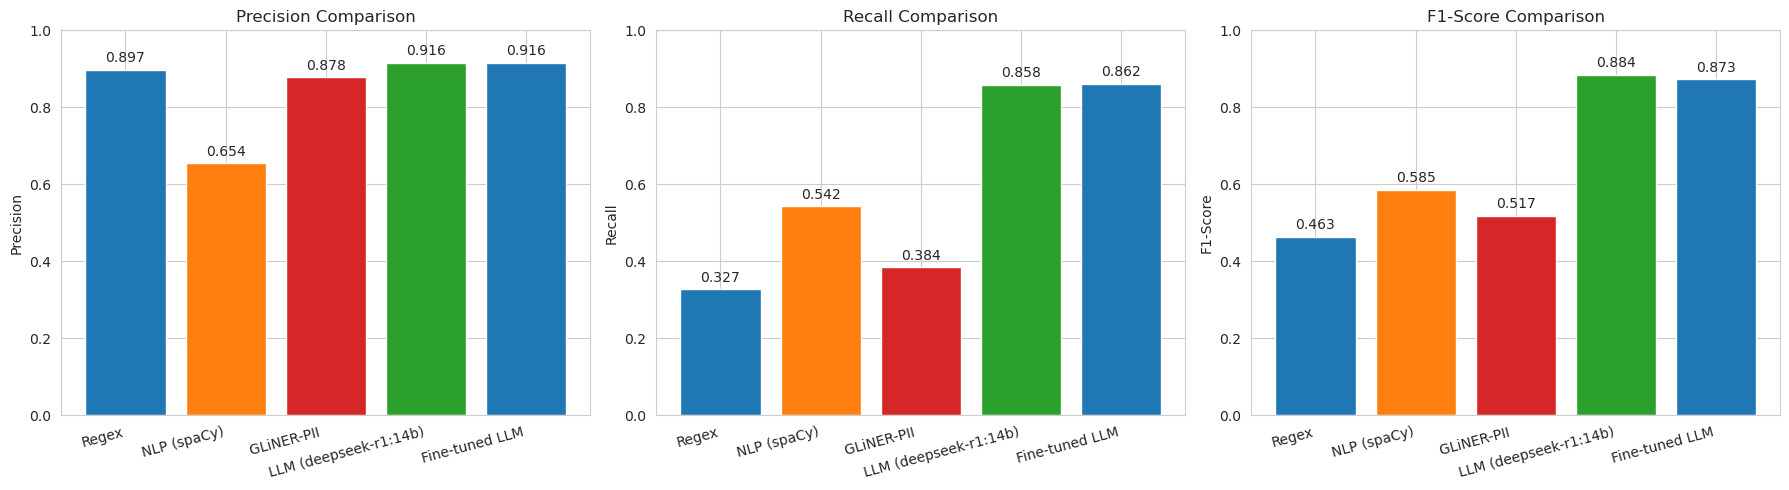

✓ Saved: method_comparison_metrics.png


In [155]:

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))


axes[0].bar(x, comparison_df['Precision'], color=['#1f77b4', '#ff7f0e', '#d62728', '#2ca02c'])
axes[0].set_ylabel('Precision')
axes[0].set_title('Precision Comparison')
axes[0].set_xticks(x)
axes[0].set_xticklabels(methods, rotation=15, ha='right')
axes[0].set_ylim(0, 1)
for i, v in enumerate(comparison_df['Precision']):
    axes[0].text(i, v + 0.02, f'{v:.3f}', ha='center')


axes[1].bar(x, comparison_df['Recall'], color=['#1f77b4', '#ff7f0e', '#d62728', '#2ca02c'])
axes[1].set_ylabel('Recall')
axes[1].set_title('Recall Comparison')
axes[1].set_xticks(x)
axes[1].set_xticklabels(methods, rotation=15, ha='right')
axes[1].set_ylim(0, 1)
for i, v in enumerate(comparison_df['Recall']):
    axes[1].text(i, v + 0.02, f'{v:.3f}', ha='center')

axes[2].bar(x, comparison_df['F1'], color=['#1f77b4', '#ff7f0e', '#d62728', '#2ca02c'])
axes[2].set_ylabel('F1-Score')
axes[2].set_title('F1-Score Comparison')
axes[2].set_xticks(x)
axes[2].set_xticklabels(methods, rotation=15, ha='right')
axes[2].set_ylim(0, 1)
for i, v in enumerate(comparison_df['F1']):
    axes[2].text(i, v + 0.02, f'{v:.3f}', ha='center')

plt.tight_layout()
plt.savefig('method_comparison_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved: method_comparison_metrics.png")

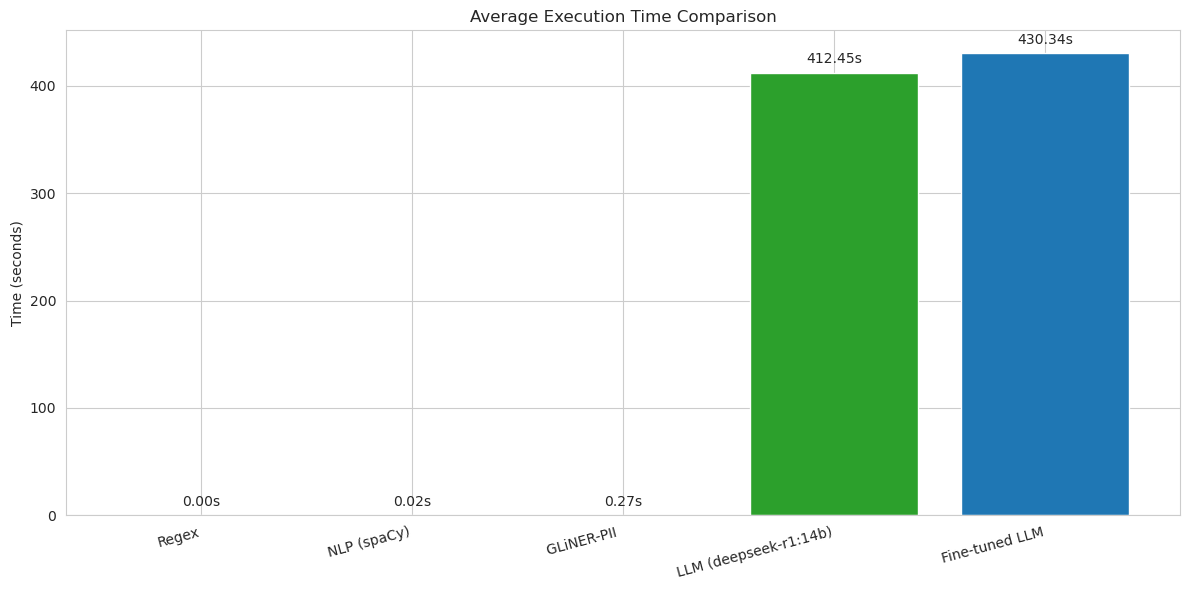

In [156]:

fig, ax = plt.subplots(1, 1, figsize=(12, 6))

colors = ['#1f77b4', '#ff7f0e', '#d62728', '#2ca02c']
bars = ax.bar(methods, comparison_df['Time (seconds)'], color=colors)
ax.set_ylabel('Time (seconds)')
ax.set_title('Average Execution Time Comparison')
ax.set_xticks(x)
ax.set_xticklabels(methods, rotation=15, ha='right')

for i, v in enumerate(comparison_df['Time (seconds)']):
    ax.text(i, v + max(comparison_df['Time (seconds)'])*0.02, f'{v:.2f}s', ha='center')

plt.tight_layout()
plt.savefig('method_comparison_time.png', dpi=300, bbox_inches='tight')
plt.show()

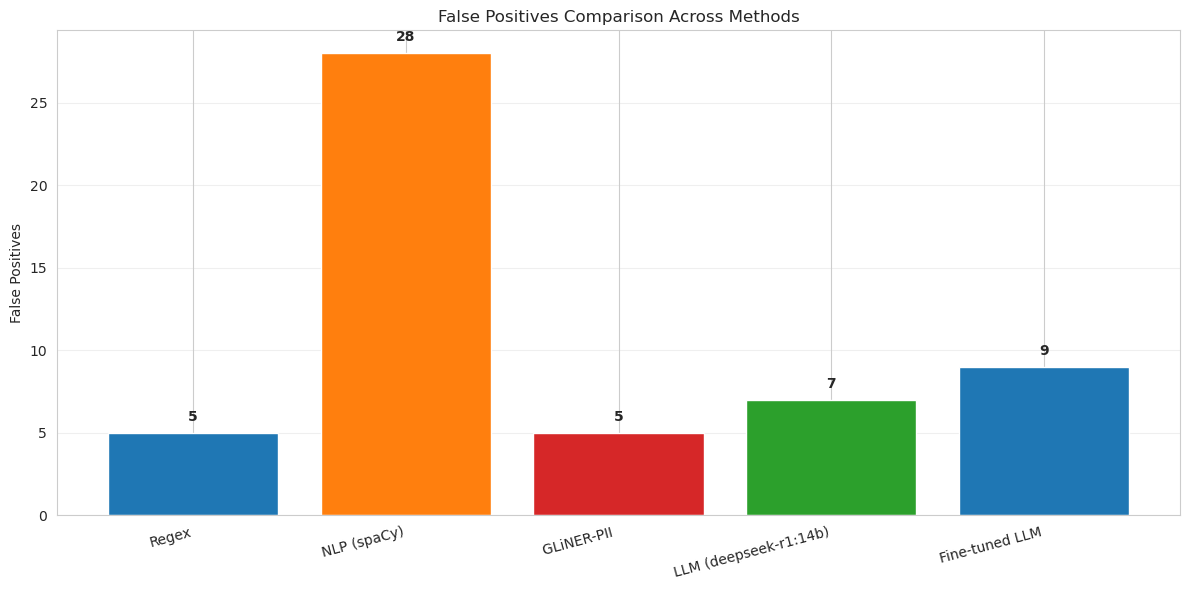

False Positives by Method:
  Regex: 5
  NLP (spaCy): 28
  GLiNER-PII : 5
  LLM (deepseek-r1:14b): 7
  Fine-tuned LLM: 9


In [157]:

fig, ax = plt.subplots(1, 1, figsize=(12, 6))


fp_values = [
    dataset["regex_metrics"]["fp"],
    dataset["nlp_metrics"]["fp"],
    dataset["PII_metrics"]["fp"],
    dataset["llm_metrics"]["fp"],
    dataset["finetuned_llm_metrics"]["fp"]
]

colors = ["#1f77b4", "#ff7f0e", "#d62728", "#2ca02c"]
bars = ax.bar(methods, fp_values, color=colors)

ax.set_ylabel("False Positives")
ax.set_title("False Positives Comparison Across Methods")
ax.set_xticks(x)
ax.set_xticklabels(methods, rotation=15, ha="right")


for i, v in enumerate(fp_values):
    ax.text(i, v + max(fp_values) * 0.02, f"{int(v)}", ha="center", va="bottom", fontsize=10, fontweight="bold")


ax.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.show()

print(f"False Positives by Method:")
for method, fp in zip(methods, fp_values):
    print(f"  {method}: {int(fp)}")

### 7.3 Method vs IoC Type Heatmap

Compare F1 scores across methods and entity types.

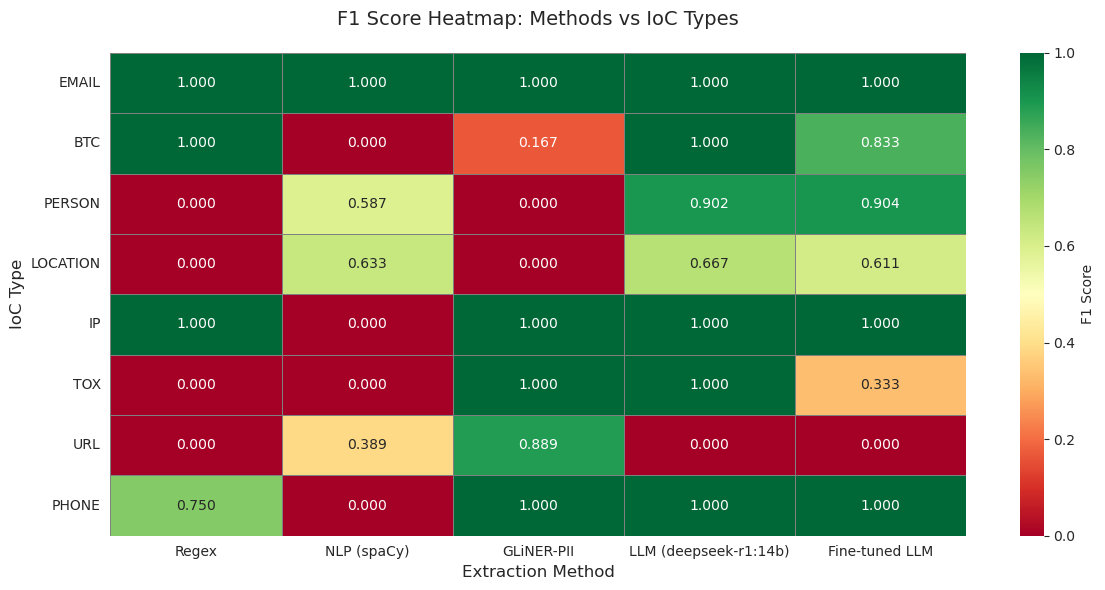

Saved: method_ioc_type_heatmap.png
F1 Scores by Method and IoC Type:
          Regex  NLP (spaCy)  GLiNER-PII  LLM (deepseek-r1:14b)  Fine-tuned LLM
EMAIL      1.00     1.000000    1.000000               1.000000        1.000000
BTC        1.00     0.000000    0.166667               1.000000        0.833333
PERSON     0.00     0.587379    0.000000               0.901832        0.903846
LOCATION   0.00     0.633333    0.000000               0.666667        0.611111
IP         1.00     0.000000    1.000000               1.000000        1.000000
TOX        0.00     0.000000    1.000000               1.000000        0.333333
URL        0.00     0.388889    0.888889               0.000000        0.000000
PHONE      0.75     0.000000    1.000000               1.000000        1.000000


In [158]:

methods = ['Regex', 'NLP (spaCy)', 'GLiNER-PII', f'LLM ({best_model})', 'Fine-tuned LLM']
ioc_types = types

f1_matrix = []

for ioc_type in ioc_types:
    type_lower = ioc_type.lower()
    row = [
        dataset['regex_type_metrics'].get(type_lower, {}).get('f1', 0.0),
        dataset['nlp_type_metrics'].get(type_lower, {}).get('f1', 0.0),
        dataset['PII_type_metrics'].get(type_lower, {}).get('f1', 0.0),
        dataset['llm_type_metrics'].get(type_lower, {}).get('f1', 0.0),
        dataset['finetuned_llm_type_metrics'].get(type_lower, {}).get('f1', 0.0)
    ]
    f1_matrix.append(row)


heatmap_df = pd.DataFrame(f1_matrix, index=ioc_types, columns=methods)

plt.figure(figsize=(12, 6))
sns.heatmap(
    heatmap_df,
    annot=True,
    fmt='.3f',
    cmap='RdYlGn',
    vmin=0,
    vmax=1,
    cbar_kws={'label': 'F1 Score'},
    linewidths=0.5,
    linecolor='gray'
)

plt.title('F1 Score Heatmap: Methods vs IoC Types', fontsize=14, pad=20)
plt.xlabel('Extraction Method', fontsize=12)
plt.ylabel('IoC Type', fontsize=12)
plt.tight_layout()
plt.savefig('method_ioc_type_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved: method_ioc_type_heatmap.png")
print("F1 Scores by Method and IoC Type:")
print(heatmap_df.to_string())

# 8 Implement privacy dataset

In [32]:
final_prompt_privacy = """
You are a cyber intelligence analyst with 20 years of experience in the the field.

Your task is to extract any entity from the input text.
The expected entity types are the following:

- EMAIL: email addresses format (user@domain.com)
- IP: IP addresses (IPv4 x.x.x.x or IPv6)
- PERSON: Human names (John Smith, John, Catalina) EXCLUDE initials (for example A.H.) 
- LOCATION: INCLUDE cities, countries, building numbers, streetnames, states, postal codes, and geographic locations ONLY physical locations EXCLUDE locations in time
- PHONE: phone numbers in any format
- USERNAME: unique identification names used for online platforms and accounts
- WEB_RESOURCE: URLs and web addresses

**Output**:
The output MUST be in a JSON object with key 'entities' and the value a list of dictionaries including every entity found. For each entity you MUST indicate the type in UPPERCASE.

**OUTPUT EXAMPLE**:
{
  "entities": [
    {"entity": "target123@darkmail.org", "type": "EMAIL"},
    {"entity": "10.45.67.89", "type": "IP"},
    {"entity": "Thompson", "type": "PERSON"},
    {"entity": "Helsinki", "type": "LOCATION"},
    {"entity": "Tim", "type": "PERSON"}
  ]
}

Return empty array if no entities found in the input text.
PAY ATTENTION to sentences that begin with entity type PERSON, for example Anna.
PAY ATTENTION to when the sentences begin with possesive forms of entity type PERSON, for example Catalina's
DO NOT include any entities from the example or the system prompt in your answer.
"""

In [31]:
from datasets import load_dataset

dataset = load_dataset("ai4privacy/pii-masking-300k")

In [33]:
df = dataset['train'].to_pandas()
df = df[df['language'] == 'English']
df = df[['source_text', 'privacy_mask', 'id']].rename(columns={'source_text': 'text', 'privacy_mask': 'gt_entities'})
df.head()

,text,gt_entities,id
0,Subject: Group Messaging for Admissions Proces...,"[{'value': 'wynqvrh053', 'start': 287, 'end': ...",40767A
1,- Meeting at 2:33 PM\n- N23 - Meeting at 11:29...,"[{'value': '2:33 PM', 'start': 13, 'end': 20, ...",40767B
2,Subject: Admission Notification - Great Britai...,"[{'value': '5:24am', 'start': 263, 'end': 269,...",40768A
3,Card: KB90324ER\n Country: GB\n Building: ...,"[{'value': 'KB90324ER', 'start': 6, 'end': 15,...",40768B
4,"N, WA14 5RW\n Password: r]iD1#8\n\n...and so...","[{'value': 'r]iD1#8', 'start': 26, 'end': 33, ...",40768C


In [34]:

df['base_id'] = df['id'].str.rstrip('ABCDEFGHIJKLMNOPQRSTUVWXYZ')


merged_df = df.groupby('base_id').agg({
    'text': lambda x: ''.join(x.astype(str)),
    'gt_entities': lambda x: [item for sublist in x for item in sublist]
}).reset_index().rename(columns={'base_id': 'id'})

merged_df.head()

,id,text,gt_entities
0,40767,Subject: Group Messaging for Admissions Proces...,"[{'value': 'wynqvrh053', 'start': 287, 'end': ..."
1,40768,Subject: Admission Notification - Great Britai...,"[{'value': '5:24am', 'start': 263, 'end': 269,..."
2,40769,Subject: Admission Application Attachments Con...,"[{'value': '301025226', 'start': 311, 'end': 3..."
3,40772,"- id_1:\n Feb 8, 1986\n iloweintögl\n 4929-...","[{'value': 'Feb 8, 1986', 'start': 10, 'end': ..."
4,40773,"""Dear [1980refad.chaïb], \n\nWe are pleased to...","[{'value': '1980refad.chaïb', 'start': 7, 'end..."


In [35]:
dataset_entity_mapping = {
    'USERNAME' : 'USERNAME',
    'EMAIL' : 'EMAIL',
    'LASTNAME1' : 'PERSON',
    'IP' : 'IP',
    'GIVENNAME1' : 'PERSON',
    'TEL' : 'PHONE',
    'CITY' : 'LOCATION',
    'POSTCODE' : 'LOCATION',
    'STREET': 'LOCATION',
    'STATE' : 'LOCATION',
    'BUILDING' : 'LOCATION',
    'COUNTRY' : 'LOCATION',
    'SECADDRESS' : 'LOCATION',
    'LASTNAME2' : 'PERSON',
    'GIVENNAME2' : 'PERSON',
    'GEOCOORD' : 'LOCATION',
    'LASTNAME3' : 'PERSON'
}

In [36]:
cleaned_entities_list = []
for idx, entities in enumerate(merged_df['gt_entities']):
    new_entities = []
    for ent in entities:
        if ent['label'] in dataset_entity_mapping.keys():
            start, end = find_entity_position(ent['value'], merged_df['text'][idx])
            new_entities.append({
                'type': dataset_entity_mapping.get(ent['label']),
                'text' : ent['value'],
                'start_pos' : start,
                'end_pos' : end
            })
    cleaned_entities_list.append(new_entities)

merged_df['gt_entities'] = cleaned_entities_list
print(len(merged_df))

10160


In [36]:
merged_df.head()

,id,text,gt_entities
0,40767,Subject: Group Messaging for Admissions Proces...,"[{'type': 'USERNAME', 'text': 'wynqvrh053', 's..."
1,40768,Subject: Admission Notification - Great Britai...,"[{'type': 'PERSON', 'text': 'Balloi', 'start_p..."
2,40769,Subject: Admission Application Attachments Con...,"[{'type': 'EMAIL', 'text': 'vtpkbqcutaxb799@ya..."
3,40772,"- id_1:\n Feb 8, 1986\n iloweintögl\n 4929-...","[{'type': 'USERNAME', 'text': 'iloweintögl', '..."
4,40773,"""Dear [1980refad.chaïb], \n\nWe are pleased to...","[{'type': 'USERNAME', 'text': '1980refad.chaïb..."


In [37]:
amount_to_test = 10
merged_df = merged_df.sample(n=amount_to_test, random_state=42).reset_index(drop=True)
merged_df.to_csv('pii_privacy_test_subset.csv', index=False)

In [84]:
llm_privacy_results = run_llm_experiments_chunks(
    [best_model],
    final_prompt_privacy,
    merged_df['text'][:5],
    merged_df['gt_entities'][:5],
    options,
    ['\n'],
    merged_df['id'][:5],
    output_file='privacy_llm_results.csv'
)

Starting LLM context chunking experiments: 5 total tests
Models: 1, chunks: 1

Testing model: deepseek-r1:14b
  12:45:37 [1/5] delimeter: 
 File: 45454 13:07:57 Success, but no F1 calculated. Time: 1334.91s
  13:07:57 [2/5] delimeter: 
 File: 48501 14:01:03 F1: 0.062, P: 0.033, R: 0.600, Time: 1528.40s
  14:01:03 [4/5] delimeter: 
 File: 43638 14:14:30 F1: 0.125, P: 0.069, R: 0.667, Time: 806.11s
  14:14:30 [5/5] delimeter: 
 File: 44759 14:56:09 F1: 0.000, P: 0.000, R: 0.000, Time: 2498.74s

✓ Results saved to privacy_llm_results.csv


In [38]:
llm_privacy_results_df = pd.read_csv('privacy_llm_results.csv')
llm_privacy_results_df

,success,predicted_entities,elapsed_time,model,prompt_strategy,delimiter,file,source text,precision,recall,f1,tp,fp,fn,gt_entities,fp_entities,fn_entities
0,True,"[{'text': 'Anna', 'type': 'person', 'start_pos...",281.880145,deepseek-r1:14b,\nYou are a cyber intelligence analyst with 20...,.,45454,**Electronic Signature Policy**\n\n**Purpose:*...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,True,"[{'text': 'hosam26@protonmail.com', 'type': 'e...",59.059268,deepseek-r1:14b,\nYou are a cyber intelligence analyst with 20...,.,48501,```yaml\n- Individuals:\n - Title: Friar\n ...,1.000000,0.250000,0.400000,2.0,0.0,6.0,"[{'type': 'EMAIL', 'text': 'hosam26@protonmail...",[],"[{'type': 'LOCATION', 'text': 'US', 'start_pos..."
2,True,"[{'text': 'Oxford', 'type': 'location', 'start...",246.671587,deepseek-r1:14b,\nYou are a cyber intelligence analyst with 20...,.,44730,Subject: Important Announcement Regarding the ...,0.375000,0.600000,0.461538,3.0,5.0,2.0,"[{'type': 'LOCATION', 'text': 'Oxford', 'start...","[{'text': 'OX1 4LE', 'type': 'location', 'star...","[{'type': 'LOCATION', 'text': 'OX1 4LE, OX1 4P..."
3,True,"[{'text': 'User', 'type': 'username', 'start_p...",441.527599,deepseek-r1:14b,\nYou are a cyber intelligence analyst with 20...,.,43638,"**Chat Conversation:**\n\nUser A: Hi there, I ...",0.500000,0.666667,0.571429,2.0,2.0,1.0,"[{'type': 'LOCATION', 'text': 'Harpenden', 'st...","[{'text': 'User', 'type': 'username', 'start_p...","[{'type': 'LOCATION', 'text': 'OL12', 'start_p..."
4,True,"[{'text': 'United Kingdom', 'type': 'location'...",59.085979,deepseek-r1:14b,\nYou are a cyber intelligence analyst with 20...,.,44759,<head>\n <title>Food and Drug Agreement</ti...,0.000000,0.000000,0.000000,0.0,1.0,1.0,"[{'type': 'LOCATION', 'text': 'ENG', 'start_po...","[{'text': 'United Kingdom', 'type': 'location'...","[{'type': 'LOCATION', 'text': 'ENG', 'start_po..."
5,True,"[{'text': 'Math Lab', 'type': 'location', 'sta...",236.122164,deepseek-r1:14b,\nYou are a cyber intelligence analyst with 20...,.,47254,"""Math Lab Equipment Inventory\n---------------...",0.375000,0.750000,0.500000,3.0,5.0,1.0,"[{'type': 'PHONE', 'text': '04.31.99 83-57', '...","[{'text': 'Math Lab', 'type': 'location', 'sta...","[{'type': 'LOCATION', 'text': '27869', 'start_..."
6,True,"[{'text': '06hellmut@aol.com', 'type': 'email'...",135.578998,deepseek-r1:14b,\nYou are a cyber intelligence analyst with 20...,.,47276,"```jsonl\n{""TITLE"":""Prince"",""USERNAME"":""06hell...",1.000000,0.105528,0.190909,10.5,0.0,89.0,"[{'type': 'USERNAME', 'text': '06hellmut', 'st...",[],"[{'type': 'LOCATION', 'text': 'US', 'start_pos..."
7,True,"[{'text': 'Lomuto', 'type': 'person', 'start_p...",145.104591,deepseek-r1:14b,\nYou are a cyber intelligence analyst with 20...,.,41089,Visa Application Form\n\nFull Name:\n- Lomuto\...,0.411765,0.583333,0.482759,7.0,10.0,5.0,"[{'type': 'PERSON', 'text': 'Lomuto', 'start_p...","[{'text': '211-643-7578', 'type': 'phone', 'st...","[{'type': 'PERSON', 'text': 'De Sangro', 'star..."
8,True,"[{'text': '07DO07@gmail.com', 'type': 'email',...",235.780580,deepseek-r1:14b,\nYou are a cyber intelligence analyst with 20...,.,45479,Subject: Private Messaging Regulations on Phot...,0.750000,1.000000,0.857143,3.0,1.0,0.0,"[{'type': 'EMAIL', 'text': '07DO07@gmail.com',...","[{'text': '6938268468', 'type': 'phone', 'star...",[]
9,True,"[{'text': 'Scolavino', 'type': 'person', 'star...",207.310489,deepseek-r1:14b,\nYou are a cyber intelligence analyst with 20...,.,48529,"{""candidate"": ""Scolavino"", ""DOB"": ""29/03/1984""...",1.000000,0.600000,0.750000,1.5,0.0,1.0,"[{'type': 'PERSON', 'text': 'Scolavino', 'star...",[],"[{'type': 'PERSON', 'text': 'Urani', 'start_po..."


Gliner-PII extraction

In [155]:

total = []
label_mapping = {
    'first_name' : 'PERSON',
    'last_name' : 'PERSON',
    'email' : 'EMAIL',
    'street_address' : 'LOCATION',
    'city' : 'LOCATION',
    'state' : 'LOCATION',
    'postcode' : 'LOCATION',
    'country' : 'LOCATION',
    'phone_number' : 'PHONE',
    'url' : 'WEB_RESOURCE',
    'ipv4' : 'IP',
    'ipv6' : 'IP',
    'user_name' : 'USERNAME'
}

for idx  in range(amount_to_test):
    text = merged_df['text'][idx]
    PII_start_time = datetime.now()
    pred_entities = model.predict_entities(text, labels=list(label_mapping.keys()))
    PII_entities = []
    for entity in pred_entities:
        PII_entities.append(
            {
                'type' : label_mapping.get(entity['label']),
                'text' : entity['text'],
                'start_pos' : entity['start'],
                'end_pos' : entity['end']
            }
        )
        
    PII_elapsed_time = (datetime.now() - PII_start_time).total_seconds()

    ner_metrics = calculate_ner_metrics(
        PII_entities,
        merged_df['gt_entities'][idx],
        match_type='partial'
    )
    ner_metrics.update({
        'file' : merged_df['id'][idx],
        'source text' : text,
        'predicted_entities' : PII_entities,
        'gt_entities' : merged_df['gt_entities'][idx],
        'elapsed_time' : PII_elapsed_time
    })

    total.append(ner_metrics)
    print(f"\n=== PII Extraction Results ===")
    print(f"Extracted {len(PII_entities)} entities in {PII_elapsed_time:.4f} seconds")

privacy_gliner_results = pd.DataFrame(total)


=== PII Extraction Results ===
Extracted 4 entities in 4.1179 seconds

=== PII Extraction Results ===
Extracted 8 entities in 1.6282 seconds

=== PII Extraction Results ===
Extracted 1 entities in 1.7144 seconds

=== PII Extraction Results ===
Extracted 0 entities in 2.0071 seconds

=== PII Extraction Results ===
Extracted 13 entities in 2.7989 seconds

=== PII Extraction Results ===
Extracted 10 entities in 1.9579 seconds

=== PII Extraction Results ===
Extracted 4 entities in 2.1161 seconds

=== PII Extraction Results ===
Extracted 2 entities in 1.9948 seconds

=== PII Extraction Results ===
Extracted 4 entities in 2.2204 seconds

=== PII Extraction Results ===
Extracted 29 entities in 5.9157 seconds


In [156]:
privacy_gliner_results

,precision,recall,f1,tp,fp,...,file,source text,predicted_entities,gt_entities,elapsed_time
0,1.000000,0.500000,0.666667,2.0,0,...,45479,Subject: Private Messaging Regulations on Phot...,"[{'type': 'EMAIL', 'text': '07DO07@gmail.com',...","[{'type': 'EMAIL', 'text': '07DO07@gmail.com',...",4.117855
1,1.000000,0.666667,0.800000,4.0,0,...,48501,```yaml\n- Individuals:\n - Title: Friar\n ...,"[{'type': 'EMAIL', 'text': 'hosam26@protonmail...","[{'type': 'EMAIL', 'text': 'hosam26@protonmail...",1.628169
2,0.000000,0.000000,0.000000,0.0,1,...,47254,"""Math Lab Equipment Inventory\n---------------...","[{'type': 'USERNAME', 'text': 'Lady', 'start_p...","[{'type': 'PHONE', 'text': '04.31.99 83-57', '...",1.714408
3,0.000000,0.000000,0.000000,0.0,0,...,45454,**Electronic Signature Policy**\n\n**Purpose:*...,[],[],2.007091
4,0.857143,0.461538,0.600000,6.0,1,...,41089,Visa Application Form\n\nFull Name:\n- Lomuto\...,"[{'type': 'PERSON', 'text': 'Lomuto', 'start_p...","[{'type': 'PERSON', 'text': 'Lomuto', 'start_p...",2.798868
5,0.428571,0.600000,0.500000,3.0,4,...,44730,Subject: Important Announcement Regarding the ...,"[{'type': 'LOCATION', 'text': 'Oxford', 'start...","[{'type': 'LOCATION', 'text': 'Oxford', 'start...",1.957916
6,1.000000,1.000000,1.000000,2.0,0,...,48529,"{""candidate"": ""Scolavino"", ""DOB"": ""29/03/1984""...","[{'type': 'PERSON', 'text': 'Scolavino', 'star...","[{'type': 'PERSON', 'text': 'Scolavino', 'star...",2.116118
7,0.333333,1.000000,0.500000,0.5,1,...,44759,<head>\n <title>Food and Drug Agreement</ti...,"[{'type': 'LOCATION', 'text': 'ENG', 'start_po...","[{'type': 'LOCATION', 'text': 'ENG', 'start_po...",1.994788
8,1.000000,0.666667,0.800000,2.0,0,...,43638,"**Chat Conversation:**\n\nUser A: Hi there, I ...","[{'type': 'LOCATION', 'text': 'Harpenden', 'st...","[{'type': 'LOCATION', 'text': 'Harpenden', 'st...",2.220432
9,0.526316,0.100000,0.168067,10.0,9,...,47276,"```jsonl\n{""TITLE"":""Prince"",""USERNAME"":""06hell...","[{'type': 'USERNAME', 'text': '06hellmut', 'st...","[{'type': 'USERNAME', 'text': '06hellmut', 'st...",5.915658


# Lets try the translated conti leaks dataset

In [30]:
conti_leaks = pd.read_csv('./Datasets/jabber_chat_2020_translated.csv')
print(len(conti_leaks))
conti_leaks = conti_leaks.rename(columns={'Unnamed: 0': 'id'})
conti_leaks.head()



107967


,id,ts,from,to,body,body_en,body_language
0,0,2020-08-23T14:06:00.707309,bentley@q3mcco35auwcstmt.onion,deploy@q3mcco35auwcstmt.onion,Привет )),Hey )),ru
1,1,2020-08-23T14:06:08.229765,marsel@q3mcco35auwcstmt.onion,hof@q3mcco35auwcstmt.onion,Привет,Hey,NaN
2,2,2020-08-23T14:06:08.231672,marsel@q3mcco35auwcstmt.onion,hof@q3mcco35auwcstmt.onion,ygybvyvuvhhvuvyvugzzzzzmmm,ygybvyvuvhhvuvyvugzzzzzmmm,ru
3,3,2020-08-23T14:06:08.234397,marsel@q3mcco35auwcstmt.onion,hof@q3mcco35auwcstmt.onion,Chil102.exe chil103.dll,Chil102.exe chil103.dll,en
4,4,2020-08-23T14:06:08.236029,bentley@q3mcco35auwcstmt.onion,hof@q3mcco35auwcstmt.onion,Свежие Чилы у Марселя,Fresh chillies near Marseille,ru


In [33]:
llm_privacy_results = run_llm_experiments_chunks(
    [best_model],
    final_prompt_privacy,
    conti_leaks['body_en'][:500],
    None,
    options,
    ['. '],
    conti_leaks['id'][:500],
    output_file='contileaks_llm_results.csv'
)

Starting LLM context chunking experiments: 500 total tests
Models: 1, chunks: 1

Testing model: deepseek-r1:14b
  02:08:40 [1/500] delimeter: .  File: 0 02:09:51 Success, but no F1 calculated. Time: 71.63s
  02:09:51 [2/500] delimeter: .  File: 1 02:10:29 Success, but no F1 calculated. Time: 37.58s
  02:10:29 [3/500] delimeter: .  File: 2 02:11:06 Success, but no F1 calculated. Time: 36.99s
  02:11:06 [4/500] delimeter: .  File: 3 02:11:36 Success, but no F1 calculated. Time: 29.80s
  02:11:36 [5/500] delimeter: .  File: 4 02:12:19 Success, but no F1 calculated. Time: 43.61s
  02:12:19 [6/500] delimeter: .  File: 5 02:14:05 Success, but no F1 calculated. Time: 105.71s
  02:14:05 [7/500] delimeter: .  File: 6 02:14:42 Success, but no F1 calculated. Time: 37.42s
  02:14:42 [8/500] delimeter: .  File: 7 02:16:02 Success, but no F1 calculated. Time: 79.27s
  02:16:02 [9/500] delimeter: .  File: 8 02:16:27 Success, but no F1 calculated. Time: 24.83s
  02:16:27 [10/500] delimeter: .  File: 9

In [83]:
import json
import csv

def convert_json_to_csv(input_path: str, output_path: str) -> None:
    with open(input_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    
    with open(output_path, 'w', newline='', encoding='utf-8') as f:
        writer = csv.writer(f)
        writer.writerow(['id', 'text', 'gt_entities'])
        
        for item in data:
            writer.writerow([
                item['message_id'],
                item['text'],
                json.dumps(item['entities'])
            ])

convert_json_to_csv(
    'ioc_annotations.json',
    'ioc_annotations.csv'
)


In [91]:
extracted = pd.read_csv('contileaks_llm_results.csv')
gt = pd.read_csv('ioc_annotations.csv')

merged = pd.merge(extracted, gt, left_on='file', right_on='id', how='inner')
merged['predicted_entities'] = merged['predicted_entities'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)
merged['gt_entities'] = merged['gt_entities'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)


In [93]:
def get_row_metrics(row):
    metrics = calculate_ner_metrics(
        list(row['predicted_entities']),  
        list(row['gt_entities']),
        match_type='partial'
    )
    return pd.Series({
        'precision': metrics['precision'],
        'recall': metrics['recall'],
        'f1': metrics['f1'],
        'tp': metrics['tp'],
        'fp': metrics['fp'],
        'fn': metrics['fn']
    })


metrics_df = merged.apply(get_row_metrics, axis=1)
merged = pd.concat([merged, metrics_df], axis=1)

In [94]:
merged

,success,predicted_entities,elapsed_time,model,prompt_strategy,delimiter,file,source text,id,text,gt_entities,precision,recall,f1,tp,fp,fn
0,True,[],71.631108,deepseek-r1:14b,\nYou are a cyber intelligence analyst with 20...,.,0,Hey )),0,Hey ))\r,[],1.0,1.0,1.0,0.0,0.0,0.0
1,True,[],37.582649,deepseek-r1:14b,\nYou are a cyber intelligence analyst with 20...,.,1,Hey,1,Hey\r,[],1.0,1.0,1.0,0.0,0.0,0.0
2,True,[],36.991791,deepseek-r1:14b,\nYou are a cyber intelligence analyst with 20...,.,2,ygybvyvuvhhvuvyvugzzzzzmmm,2,ygybvyvuvhhvuvyvugzzzzzmmm\r,[],1.0,1.0,1.0,0.0,0.0,0.0
3,True,[],29.799374,deepseek-r1:14b,\nYou are a cyber intelligence analyst with 20...,.,3,Chil102.exe chil103.dll,3,Chil102.exe chil103.dll\r,[],1.0,1.0,1.0,0.0,0.0,0.0
4,True,"[{'text': 'Marseille', 'type': 'location', 'st...",43.610066,deepseek-r1:14b,\nYou are a cyber intelligence analyst with 20...,.,4,Fresh chillies near Marseille,4,Fresh chillies near Marseille\r,"[{'text': 'Marseille', 'type': 'LOCATION', 'st...",1.0,1.0,1.0,0.5,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,True,"[{'text': 'Moscow', 'type': 'location', 'start...",36.217221,deepseek-r1:14b,\nYou are a cyber intelligence analyst with 20...,.,495,"it usually happens later, after 17:00 Moscow time",495,"""if in the crypt",[],0.0,0.0,0.0,0.0,1.0,0.0
496,True,"[{'text': 'Stern', 'type': 'username', 'start_...",25.438806,deepseek-r1:14b,\nYou are a cyber intelligence analyst with 20...,.,496,[10:55:25]<Stern> you&#39;re here? [10:56:42]<...,496,"""Hello",[],0.0,0.0,0.0,0.0,2.0,0.0
497,True,[],35.580439,deepseek-r1:14b,\nYou are a cyber intelligence analyst with 20...,.,497,mors should load every day in the second admin...,497,what happened to him yesterday?\r,[],1.0,1.0,1.0,0.0,0.0,0.0
498,True,[],41.685752,deepseek-r1:14b,\nYou are a cyber intelligence analyst with 20...,.,498,write on it every 2 hours what happens,498,Ghbdtn\r,[],1.0,1.0,1.0,0.0,0.0,0.0


In [ ]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

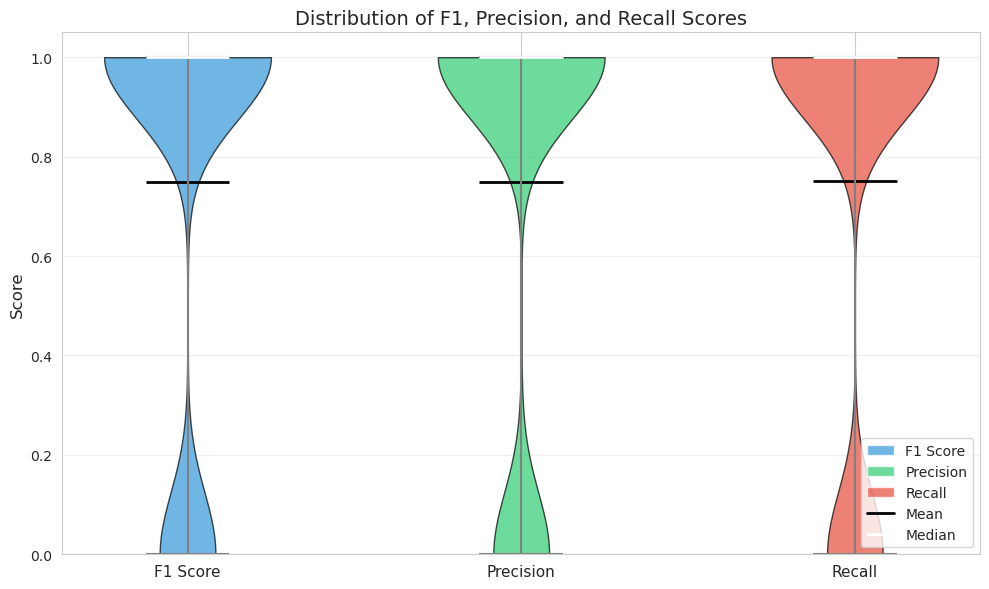

Summary Statistics:
F1 Score    - Mean: 0.749, Median: 1.000, Std: 0.433
Precision   - Mean: 0.749, Median: 1.000, Std: 0.434
Recall      - Mean: 0.750, Median: 1.000, Std: 0.433


In [ ]:

fig, ax = plt.subplots(figsize=(10, 6))


metrics_data = [merged['f1'].dropna(), merged['precision'].dropna(), merged['recall'].dropna()]
labels = ['F1 Score', 'Precision', 'Recall']
colors = ['#3498db', '#2ecc71', '#e74c3c']


vp = ax.violinplot(metrics_data, positions=[1, 2, 3], showmeans=True, showmedians=True)


for i, body in enumerate(vp['bodies']):
    body.set_facecolor(colors[i])
    body.set_alpha(0.7)
    body.set_edgecolor('black')


vp['cmeans'].set_color('black')
vp['cmeans'].set_linewidth(2)
vp['cmedians'].set_color('white')
vp['cmedians'].set_linewidth(2)
vp['cbars'].set_color('gray')
vp['cmaxes'].set_color('gray')
vp['cmins'].set_color('gray')


ax.set_xticks([1, 2, 3])
ax.set_xticklabels(labels, fontsize=11)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Distribution of F1, Precision, and Recall Scores Contileaks dataset', fontsize=14)
ax.set_ylim(0, 1.05)
ax.grid(axis='y', alpha=0.3)


legend_elements = [
    Patch(facecolor=colors[0], alpha=0.7, label='F1 Score'),
    Patch(facecolor=colors[1], alpha=0.7, label='Precision'),
    Patch(facecolor=colors[2], alpha=0.7, label='Recall'),
    Line2D([0], [0], color='black', linewidth=2, label='Mean'),
    Line2D([0], [0], color='white', linewidth=2, label='Median')
]
ax.legend(handles=legend_elements, loc='lower right')

plt.tight_layout()
plt.show()


print("Summary Statistics:")
print(f"F1 Score    - Mean: {merged['f1'].mean():.3f}, Median: {merged['f1'].median():.3f}, Std: {merged['f1'].std():.3f}")
print(f"Precision   - Mean: {merged['precision'].mean():.3f}, Median: {merged['precision'].median():.3f}, Std: {merged['precision'].std():.3f}")
print(f"Recall      - Mean: {merged['recall'].mean():.3f}, Median: {merged['recall'].median():.3f}, Std: {merged['recall'].std():.3f}")